In [1]:
import sys
sys.path.append("..")

## Libraries

In [2]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

## Load the data

In [ ]:
from utils.helper import *

In [4]:
df = pd.read_csv("../data/Final_Btc_Data_with_Indicators.csv", parse_dates=['Date'])

In [5]:
target_col = "Price"
features = [col for col in df.columns if col != target_col and col != "Date"]

In [6]:
df = scaled_data(df)

In [7]:
seq_len = 5
horizon = 1
X, y = create_sequences(df[features].values, df[target_col].values, seq_len, horizon)

## Dataloaders

In [8]:
batch_size = 256

train_loader, val_loader, test_loader = data_loaders(df, X, y, batch_size=batch_size)

# LSTM

In [9]:
# torch.Size([256, 5, 14]) -> [B, T, F]
# torch.Size([256])        -> [B]

In [10]:
class BaselineLSTM(nn.Module):
    def __init__(self, input_dim, hidden1=64, hidden2=32, dropout=0.2):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=input_dim, hidden_size=hidden1, batch_first=True)
        self.drop1 = nn.Dropout(dropout)
        self.lstm2 = nn.LSTM(input_size=hidden1, hidden_size=hidden2, batch_first=True)
        self.fc = nn.Linear(hidden2, 1)

    def forward(self, x):
        # x: (B, T, F)
        out, _ = self.lstm1(x)
        out = self.drop1(out)
        out, _ = self.lstm2(out)

        # take last time step
        out = out[:, -1, :]
        out = self.fc(out)
        return out.squeeze(-1)    # (B,)

In [11]:
lstm = BaselineLSTM(input_dim=len(features))

In [12]:
# Device
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='mps')

In [13]:
# Training the model using the train_loader, val_loader, and test_loader
lstm = lstm.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)

num_epochs = 300
best_val_loss = float('inf')
patience = 10
patience_counter = 0

train_losses = []
val_losses = []

print(f"Training on device: {device}")
print(f"Model parameters: {sum(p.numel() for p in lstm.parameters())}")

for epoch in range(num_epochs):

    print(f"{'='*40}")
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"{'-'*40}")

    lstm.train()
    train_loss = 0.0

    for batch_x, batch_y in tqdm(train_loader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = lstm(batch_x)
        loss = criterion(outputs, batch_y)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    lstm.eval()
    val_loss = 0.0

    with torch.no_grad():
        for batch_x, batch_y in tqdm(val_loader):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            outputs = lstm(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(lstm.state_dict(), '../models/lstm5.pth')
    else:
        patience_counter += 1

    # if epoch % 10 == 0 or epoch == num_epochs - 1:
    print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')

    # Early stopping check
    if patience_counter >= patience:
        print(f'Early stopping triggered after epoch {epoch+1}')
        break

print(f'\nBest validation loss: {best_val_loss:.6f}')

Training on device: mps
Model parameters: 33057
Epoch 1/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 60.57it/s]


Epoch [1/300] - Train Loss: 1.011703, Val Loss: 17.099582
Epoch 2/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 382.71it/s]


Epoch [2/300] - Train Loss: 0.816238, Val Loss: 15.658063
Epoch 3/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 381.68it/s]


Epoch [3/300] - Train Loss: 0.648586, Val Loss: 14.043451
Epoch 4/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 427.08it/s]


Epoch [4/300] - Train Loss: 0.534783, Val Loss: 12.311041
Epoch 5/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 431.05it/s]


Epoch [5/300] - Train Loss: 0.459897, Val Loss: 10.448793
Epoch 6/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 375.11it/s]


Epoch [6/300] - Train Loss: 0.380296, Val Loss: 8.591357
Epoch 7/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 387.38it/s]


Epoch [7/300] - Train Loss: 0.302679, Val Loss: 6.858128
Epoch 8/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 360.83it/s]


Epoch [8/300] - Train Loss: 0.233372, Val Loss: 5.288665
Epoch 9/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 392.54it/s]


Epoch [9/300] - Train Loss: 0.177707, Val Loss: 3.940609
Epoch 10/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 436.02it/s]


Epoch [10/300] - Train Loss: 0.136706, Val Loss: 2.932724
Epoch 11/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 394.09it/s]


Epoch [11/300] - Train Loss: 0.106950, Val Loss: 2.263743
Epoch 12/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 374.88it/s]


Epoch [12/300] - Train Loss: 0.086456, Val Loss: 1.806711
Epoch 13/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 401.52it/s]


Epoch [13/300] - Train Loss: 0.071151, Val Loss: 1.462218
Epoch 14/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 422.56it/s]


Epoch [14/300] - Train Loss: 0.060624, Val Loss: 1.205370
Epoch 15/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 399.46it/s]


Epoch [15/300] - Train Loss: 0.052487, Val Loss: 1.052727
Epoch 16/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 438.18it/s]


Epoch [16/300] - Train Loss: 0.046537, Val Loss: 0.900464
Epoch 17/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 463.59it/s]


Epoch [17/300] - Train Loss: 0.043883, Val Loss: 0.840442
Epoch 18/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 393.65it/s]


Epoch [18/300] - Train Loss: 0.048058, Val Loss: 0.687796
Epoch 19/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 431.31it/s]


Epoch [19/300] - Train Loss: 0.049746, Val Loss: 0.781389
Epoch 20/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 383.87it/s]


Epoch [20/300] - Train Loss: 0.044335, Val Loss: 0.594907
Epoch 21/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 410.52it/s]


Epoch [21/300] - Train Loss: 0.031900, Val Loss: 0.643284
Epoch 22/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 416.14it/s]


Epoch [22/300] - Train Loss: 0.027038, Val Loss: 0.590534
Epoch 23/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 378.74it/s]


Epoch [23/300] - Train Loss: 0.024812, Val Loss: 0.534216
Epoch 24/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 443.47it/s]


Epoch [24/300] - Train Loss: 0.022188, Val Loss: 0.504378
Epoch 25/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 379.06it/s]


Epoch [25/300] - Train Loss: 0.021280, Val Loss: 0.465249
Epoch 26/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 446.23it/s]


Epoch [26/300] - Train Loss: 0.019747, Val Loss: 0.450257
Epoch 27/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 386.16it/s]


Epoch [27/300] - Train Loss: 0.020260, Val Loss: 0.432514
Epoch 28/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 405.11it/s]


Epoch [28/300] - Train Loss: 0.025682, Val Loss: 0.423707
Epoch 29/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 386.02it/s]


Epoch [29/300] - Train Loss: 0.036400, Val Loss: 0.460598
Epoch 30/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 405.19it/s]


Epoch [30/300] - Train Loss: 0.027298, Val Loss: 0.449823
Epoch 31/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 437.82it/s]


Epoch [31/300] - Train Loss: 0.016649, Val Loss: 0.406275
Epoch 32/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 384.46it/s]


Epoch [32/300] - Train Loss: 0.013892, Val Loss: 0.390061
Epoch 33/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 434.13it/s]


Epoch [33/300] - Train Loss: 0.012846, Val Loss: 0.382187
Epoch 34/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 399.67it/s]


Epoch [34/300] - Train Loss: 0.012279, Val Loss: 0.380703
Epoch 35/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 449.82it/s]


Epoch [35/300] - Train Loss: 0.010926, Val Loss: 0.367677
Epoch 36/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 417.80it/s]


Epoch [36/300] - Train Loss: 0.010302, Val Loss: 0.365667
Epoch 37/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 416.76it/s]


Epoch [37/300] - Train Loss: 0.009922, Val Loss: 0.362420
Epoch 38/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 409.24it/s]


Epoch [38/300] - Train Loss: 0.009697, Val Loss: 0.367536
Epoch 39/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 393.94it/s]


Epoch [39/300] - Train Loss: 0.009398, Val Loss: 0.352909
Epoch 40/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 385.97it/s]


Epoch [40/300] - Train Loss: 0.009847, Val Loss: 0.364006
Epoch 41/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 429.63it/s]


Epoch [41/300] - Train Loss: 0.010166, Val Loss: 0.345998
Epoch 42/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 421.52it/s]


Epoch [42/300] - Train Loss: 0.011717, Val Loss: 0.398133
Epoch 43/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 422.30it/s]


Epoch [43/300] - Train Loss: 0.013637, Val Loss: 0.348701
Epoch 44/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 408.72it/s]


Epoch [44/300] - Train Loss: 0.018166, Val Loss: 0.448867
Epoch 45/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 365.96it/s]


Epoch [45/300] - Train Loss: 0.015945, Val Loss: 0.372207
Epoch 46/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 394.87it/s]


Epoch [46/300] - Train Loss: 0.012793, Val Loss: 0.400158
Epoch 47/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 380.64it/s]


Epoch [47/300] - Train Loss: 0.010201, Val Loss: 0.359144
Epoch 48/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 411.61it/s]


Epoch [48/300] - Train Loss: 0.008178, Val Loss: 0.350939
Epoch 49/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 463.41it/s]


Epoch [49/300] - Train Loss: 0.007638, Val Loss: 0.338436
Epoch 50/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 400.24it/s]


Epoch [50/300] - Train Loss: 0.006905, Val Loss: 0.343300
Epoch 51/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 425.45it/s]


Epoch [51/300] - Train Loss: 0.007001, Val Loss: 0.328147
Epoch 52/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 385.59it/s]


Epoch [52/300] - Train Loss: 0.007183, Val Loss: 0.345937
Epoch 53/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 404.29it/s]


Epoch [53/300] - Train Loss: 0.007041, Val Loss: 0.328031
Epoch 54/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 432.31it/s]


Epoch [54/300] - Train Loss: 0.007696, Val Loss: 0.364505
Epoch 55/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 378.38it/s]


Epoch [55/300] - Train Loss: 0.008054, Val Loss: 0.316521
Epoch 56/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 426.99it/s]


Epoch [56/300] - Train Loss: 0.009563, Val Loss: 0.385446
Epoch 57/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 402.33it/s]


Epoch [57/300] - Train Loss: 0.010091, Val Loss: 0.331480
Epoch 58/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 404.70it/s]


Epoch [58/300] - Train Loss: 0.013330, Val Loss: 0.419260
Epoch 59/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 395.04it/s]


Epoch [59/300] - Train Loss: 0.011575, Val Loss: 0.360377
Epoch 60/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 415.20it/s]


Epoch [60/300] - Train Loss: 0.011711, Val Loss: 0.379636
Epoch 61/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 413.72it/s]


Epoch [61/300] - Train Loss: 0.009612, Val Loss: 0.345089
Epoch 62/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 424.18it/s]


Epoch [62/300] - Train Loss: 0.009232, Val Loss: 0.373885
Epoch 63/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 415.48it/s]


Epoch [63/300] - Train Loss: 0.007928, Val Loss: 0.332038
Epoch 64/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 429.11it/s]


Epoch [64/300] - Train Loss: 0.006865, Val Loss: 0.329786
Epoch 65/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 401.29it/s]

Epoch [65/300] - Train Loss: 0.006249, Val Loss: 0.316660
Early stopping triggered after epoch 65

Best validation loss: 0.316521


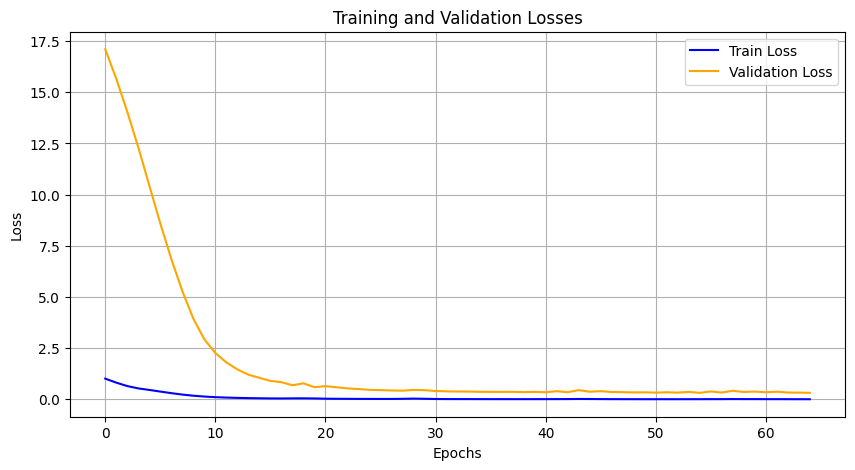

In [14]:
import matplotlib.pyplot as plt

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid()
plt.show()

In [15]:
# Load best model for testing
lstm.load_state_dict(torch.load('../models/lstm5.pth'))

<All keys matched successfully>

In [16]:
# Test phase
lstm.eval()
test_loss = 0.0
test_predictions = []
test_targets = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        outputs = lstm(batch_x)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()

        test_predictions.extend(outputs.cpu().numpy())
        test_targets.extend(batch_y.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
print(f'Test Loss: {avg_test_loss:.6f}')

# Convert to numpy arrays for analysis
test_predictions = np.array(test_predictions)
test_targets = np.array(test_targets)

Test Loss: 0.214671


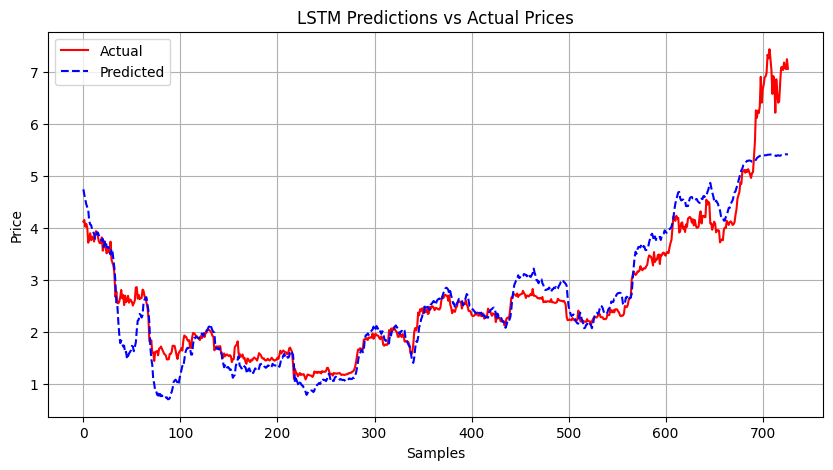

In [18]:
# plot predictions vs targets
plt.figure(figsize=(10, 5))
plt.plot(test_targets, label='Actual', color='red')
plt.plot(test_predictions, label='Predicted', color='blue', linestyle='--')
plt.xlabel('Samples')
plt.ylabel('Price')
plt.title('LSTM Predictions vs Actual Prices')
plt.legend()
plt.grid()
plt.show()